### Intro
In this file, we will perform sentiment analysis on some data using BERT: the steps are as follow:
    - we will use a prelabelled dataset related to opinions on self driving cars to train the model
    - we will use the pre trained model to classify our dataset sentiments
    
    in the data preprocessing, we need to :
punctuation was removed,
text was coverted to lower case,
URLS were removed
“_” was removed,
“RT” was removed,
”@” sign was removed,
hashtags were removed,
numbers were removed,
text was lemmatized.

In [1]:
#lib
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english", ignore_stopwords=True)

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
# kaggle competitions download -c twitter-sentiment-analysis-self-driving-cars

In [2]:
# getting the data and cleaning:

#with open ('Twitter-sentiment-self-drive-DFE.csv','rb')as f:
#    contents=f.read()
    
df = pd.read_csv("Twitter-sentiment-self-drive-DFE.csv", encoding_errors='ignore')
df.head(3)


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,sentiment_gold,sentiment_gold_reason,text
0,724227031,True,golden,236,NaN,5,0.7579,10001,5\n4,Author is excited about the development of the...,Two places I'd invest all my money if I could:...
1,724227032,True,golden,231,NaN,5,0.8775,10002,5\n4,Author is excited that driverless cars will be...,Awesome! Google driverless cars will help the ...
2,724227033,True,golden,233,NaN,2,0.6805,10003,2\n1,The author is skeptical of the safety and reli...,If Google maps can't keep up with road constru...


In [66]:
# let's save the text and sentiment we're only interested in
dataset= pd.DataFrame(df.loc[:,'sentiment'])
#,df.loc[:,'text']
dataset['tweet']=df.loc[:,'text']
dataset.head(2)

,sentiment,tweet
0,5,Two places I'd invest all my money if I could:...
1,5,Awesome! Google driverless cars will help the ...


In [67]:
dataset.shape
#7k tweets

(7156, 2)

In [68]:
#dataset.info()

#checking unique values in the dataset and removing the "NOT_Relevant" sentiments
df2 =dataset.drop_duplicates()

print(df2.shape)
print(df2['sentiment'].unique())
#df2['sentiment'].value_counts()

# replacing 'not_relevant with nan values'
df2=df2.replace('not_relevant', np.nan)
df2=df2.dropna()
print(df2['sentiment'].value_counts())

(7147, 2)
['5' '2' '3' 'not_relevant' '1' '4']
3    4236
4    1444
2     685
5     459
1     110
Name: sentiment, dtype: int64


In [69]:
# WORDNET LEMMATIZER (with appropriate pos tags)

lemmatizer = WordNetLemmatizer()

# Define function to lemmatize each word with its POS tag

# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
	if nltk_tag.startswith('J'):
		return wordnet.ADJ
	elif nltk_tag.startswith('V'):
		return wordnet.VERB
	elif nltk_tag.startswith('N'):
		return wordnet.NOUN
	elif nltk_tag.startswith('R'):
		return wordnet.ADV
	else:		
		return None

def lemmatization(sentence):
    # tokenize the sentence and find the POS tag for each token
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))

    # we use our own pos_tagger function to make things simpler to understand.
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:	
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)

    return lemmatized_sentence


In [70]:
# cleaning the Data 

# 1. removing twitter handkes


def remove_pattern(input_text, pattern):
    r=re.findall(pattern,input_text)
    for i in r:
        input_text=re.sub(i,'',input_text)
    return input_text

def cleaning_data(df2):
    df2 =df2.drop_duplicates()
    
    # 2.removing tweeter handles @user
    df2['clean_twt'] = np.vectorize(remove_pattern)(df2['tweet'],'@[\w]*')
    df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)

    # 3.rm punctuation, numbers, special char
    df2['clean_twt'] = df2['clean_twt'].str.replace('[^A-Za-z0-9]+',' ')
    df2['clean_twt'] = df2['clean_twt'].apply (lambda x : ' '.join([item for item in str(x).split() if not item.isdigit()]))

    # 5. lowercase
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ''.join([w for w in x.lower()]))

    stop = stopwords.words('english')
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([item for item in str(x).split() if item not in stop]))
    
    #lemmatization with context
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([ lemmatization(item) for item in str(x).split() if item not in stop]))

    #lemmatization noun context
   # df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([ wordnet_lemmatizer.lemmatize(item) for item in str(x).split() if item not in stop]))

    #lemmatization adj context
    #df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([ wordnet_lemmatizer.lemmatize(item, pos="J") for item in str(x).split() if item not in stop]))

    #4.RM Stopwords
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    
    return df2

df2= cleaning_data(df2)
df2.head()



/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_7853/3033460231.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_7853/3033460231.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('[^A-Za-z0-9]+',' ')


,sentiment,tweet,clean_twt
0,5,Two places I'd invest all my money if I could:...,two place invest money could printing self dri...
1,5,Awesome! Google driverless cars will help the ...,awesome google driverless car help blind trave...
2,2,If Google maps can't keep up with road constru...,google map keep road construction suppose trus...
3,2,Autonomous cars seem way overhyped given the t...,autonomous car seem way overhyped give technol...
4,3,Just saw Google self-driving car on I-34. It w...,saw google self drive car paint green blue


/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


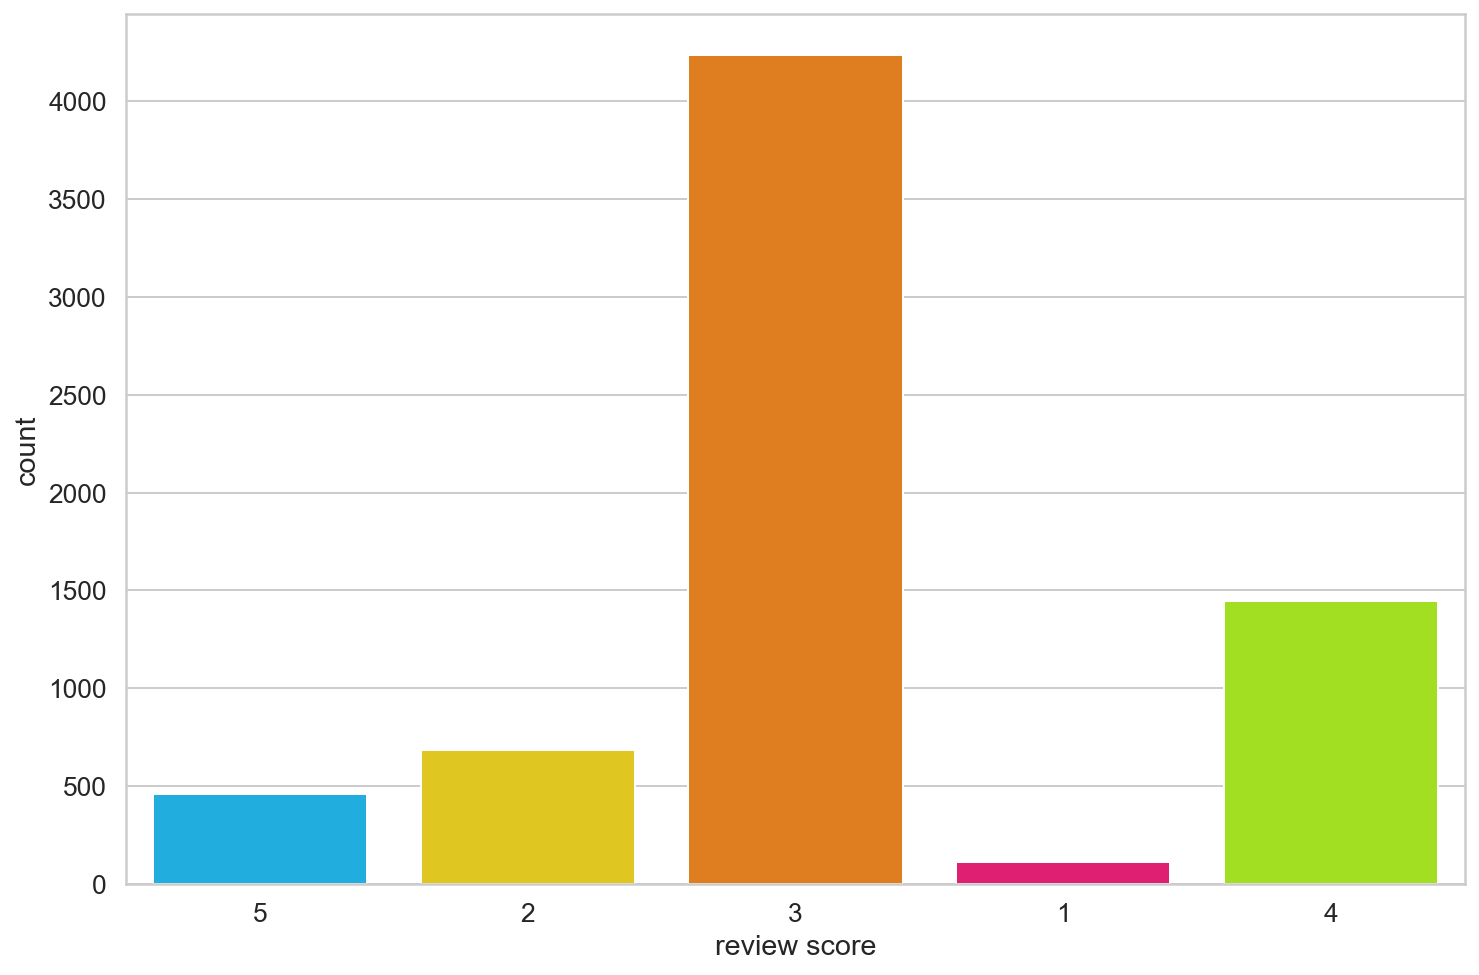

In [71]:
# now let's analyze the data
sns.countplot(df2.sentiment)
plt.xlabel('review score');

/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


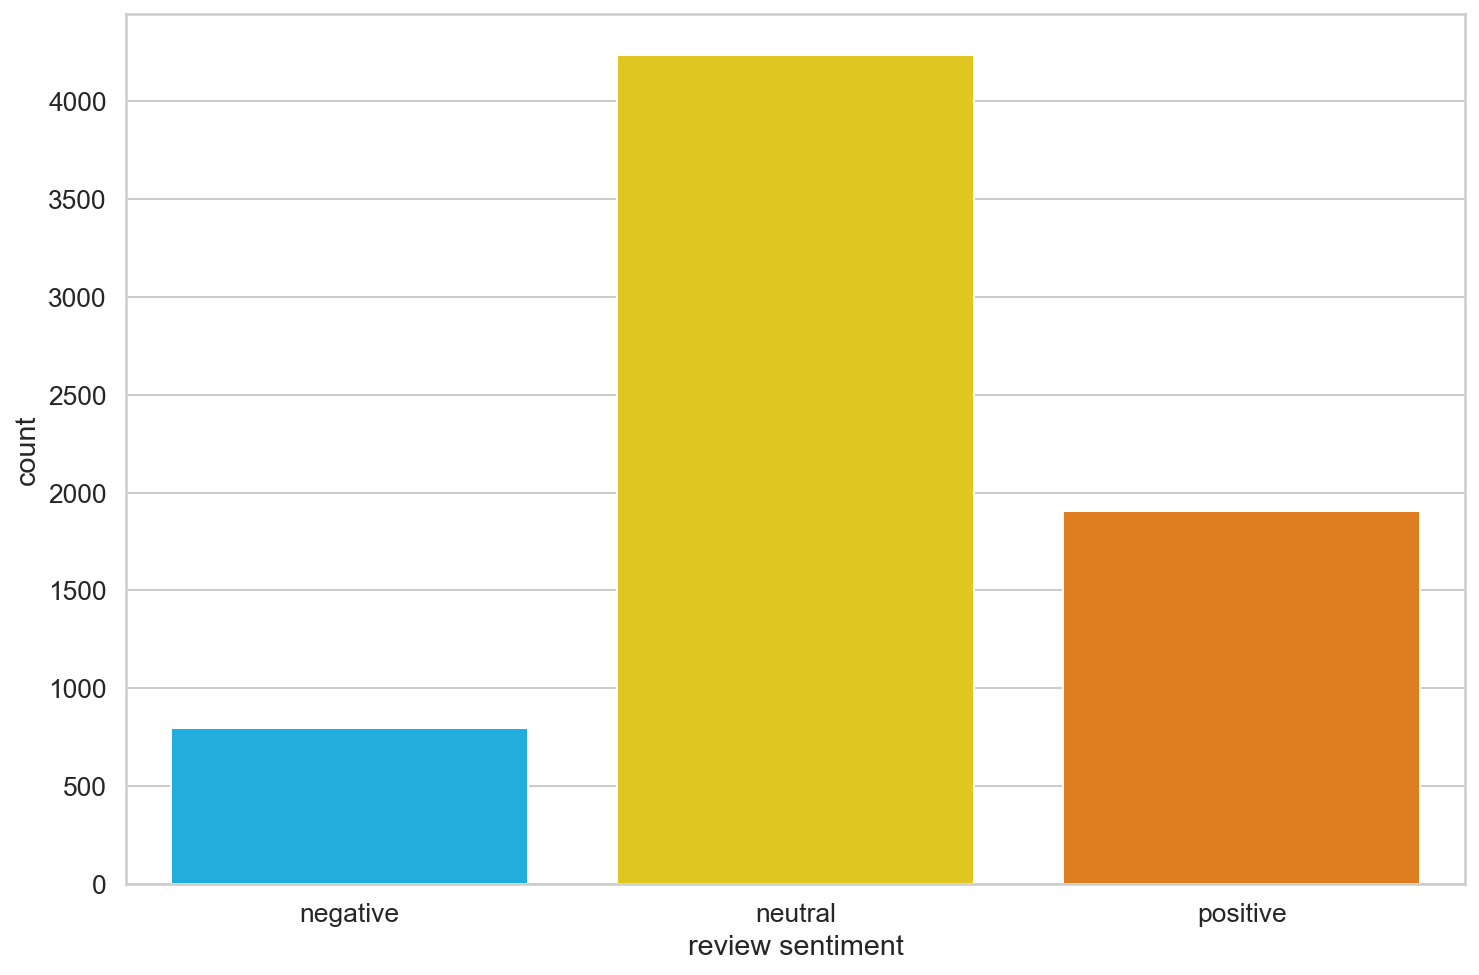

In [72]:
# data is hugely imbalanced, need to balance it to train the model efficiently
# let's define 3 categories only:   negative, neutral and positive sentiment:

def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df2['sentiment'] = df2.sentiment.apply(to_sentiment)

class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df2.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

### IMPORTANT: look into SMOTE or other to balance the dataset 

In [73]:
# BERT Data preprocessing:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# bert tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# bert classification
# sep - to mark ending of a sentence
# cls - mark start of a sentence
# padding token
# unknown token for the rest

'''
encoding = tokenizer.encode_plus(
  input_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

'''


"\nencoding = tokenizer.encode_plus(\n  input_txt,\n  max_length=32,\n  add_special_tokens=True, # Add '[CLS]' and '[SEP]'\n  return_token_type_ids=False,\n  pad_to_max_length=True,\n  return_attention_mask=True,\n  return_tensors='pt',  # Return PyTorch tensors\n)\n\nencoding.keys()\n\n"

In [92]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


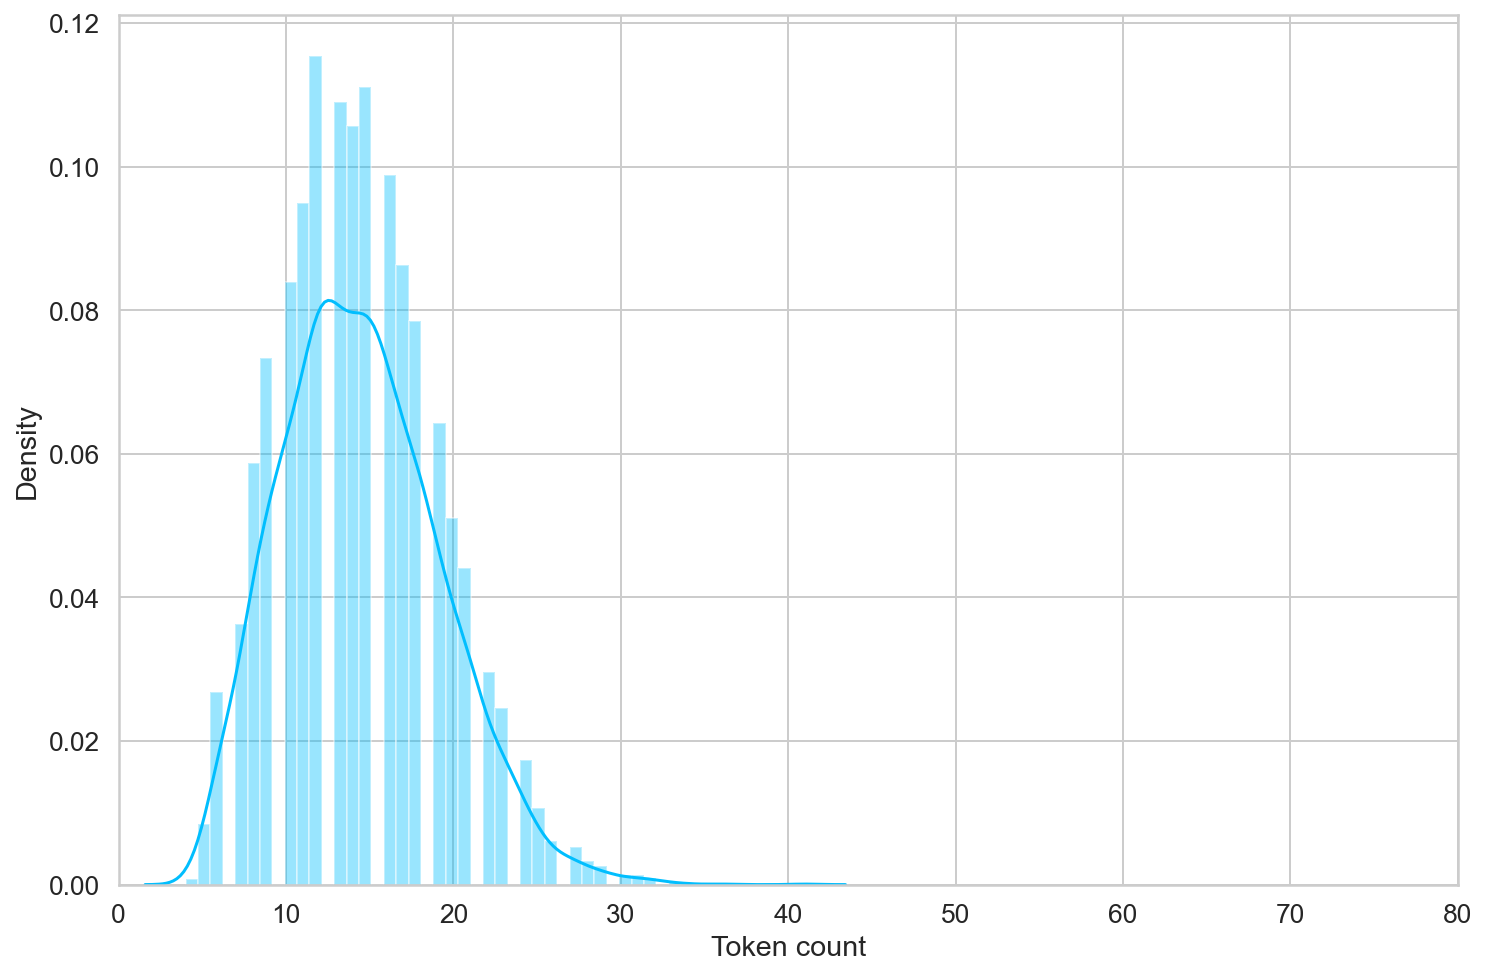

In [74]:
#Choosing Sequence Length
#BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:
token_lens = []

for txt in df2.clean_twt:
    tokens = tokenizer.encode(txt, max_length=812)
    token_lens.append(len(tokens))
#plot distrib 
sns.distplot(token_lens)
plt.xlim([0, 80]);
plt.xlabel('Token count');

In [75]:
# most reviews have less than 30 tokens, so we'll set max len to 35
MAX_LEN = 40


In [76]:
# creating the pytorch dataset:

class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          #padding= 'longest',
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

#returning the tweet to better evaluate our predictions

In [77]:
# let's split our dataset

df_train, df_test = train_test_split(df2, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((6240, 3), (347, 3), (347, 3))

In [78]:
# data loader helper function
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.clean_twt.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
      )

In [79]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# look into example batch and data loader
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 40])
torch.Size([16, 40])
torch.Size([16])


/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [80]:
#train_data_loader.dataset.reviews

### Sentiment Classification with BERT and Hugging Face


In [16]:
# from transformers import BertTokenizer, BertForMaskedLM, BertModel


In [17]:
# import torch
# print(torch.__version__)

In [18]:
# loading bert model 
#bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [19]:
# bert classifier
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        #outputs = self.bert(**inputs)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)



In [81]:
# moving the pytorch model to the GPU
model1 = SentimentClassifier(len(class_names))
model1 = model1.to(device)

# moving the example batch of the training data to the GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([16, 40])
torch.Size([16, 40])


3

In [21]:
#type(input_ids[0])

In [82]:
# getting the predicted probabilities from the trained model with softmax function
F.softmax(model1(input_ids, attention_mask), dim=1)



tensor([[0.5811, 0.1816, 0.2373],
        [0.6254, 0.1590, 0.2156],
        [0.6352, 0.1102, 0.2546],
        [0.6289, 0.1030, 0.2681],
        [0.6698, 0.1421, 0.1881],
        [0.5669, 0.1055, 0.3277],
        [0.3527, 0.1512, 0.4961],
        [0.6787, 0.0965, 0.2249],
        [0.4934, 0.0988, 0.4078],
        [0.6774, 0.1380, 0.1846],
        [0.5893, 0.1538, 0.2569],
        [0.5351, 0.1433, 0.3216],
        [0.5865, 0.1777, 0.2359],
        [0.3997, 0.1601, 0.4402],
        [0.6264, 0.1241, 0.2495],
        [0.5597, 0.1522, 0.2880]], grad_fn=<SoftmaxBackward0>)

In [23]:
# TRAINING THE MODEL
'''
How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
'''

'\nHow do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:\n\nBatch size: 16, 32\nLearning rate (Adam): 5e-5, 3e-5, 2e-5\nNumber of epochs: 2, 3, 4\n'

In [83]:
EPOCHS = 6

optimizer = AdamW(model1.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [84]:
# TRAINING function
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
                ):
    
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [85]:
# EVALUATION function to evaluate the model
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
                  )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [87]:
# training loop
#%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model1,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
      )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model1,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
      )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model1.state_dict(), 'best_model_state_unbalanced.bin')
        best_accuracy = val_acc

Epoch 1/6
----------
Train loss 0.8265798402138246 accuracy 0.6551282051282051
Val   loss 0.8178777654062618 accuracy 0.6829971181556196

Epoch 2/6
----------
Train loss 0.6755802531272938 accuracy 0.7434294871794872
Val   loss 0.7195721160281788 accuracy 0.7262247838616714

Epoch 3/6
----------
Train loss 0.5439468562029875 accuracy 0.8051282051282052
Val   loss 0.7599355944178321 accuracy 0.7204610951008645

Epoch 4/6
----------
Train loss 0.4384757353231693 accuracy 0.8576923076923076
Val   loss 0.8713460408828475 accuracy 0.6945244956772334

Epoch 5/6
----------
Train loss 0.3633343994139861 accuracy 0.8873397435897435
Val   loss 0.9688402502374216 accuracy 0.6858789625360231

Epoch 6/6
----------
Train loss 0.3207449093126716 accuracy 0.9008012820512821
Val   loss 0.9762165857986971 accuracy 0.69164265129683



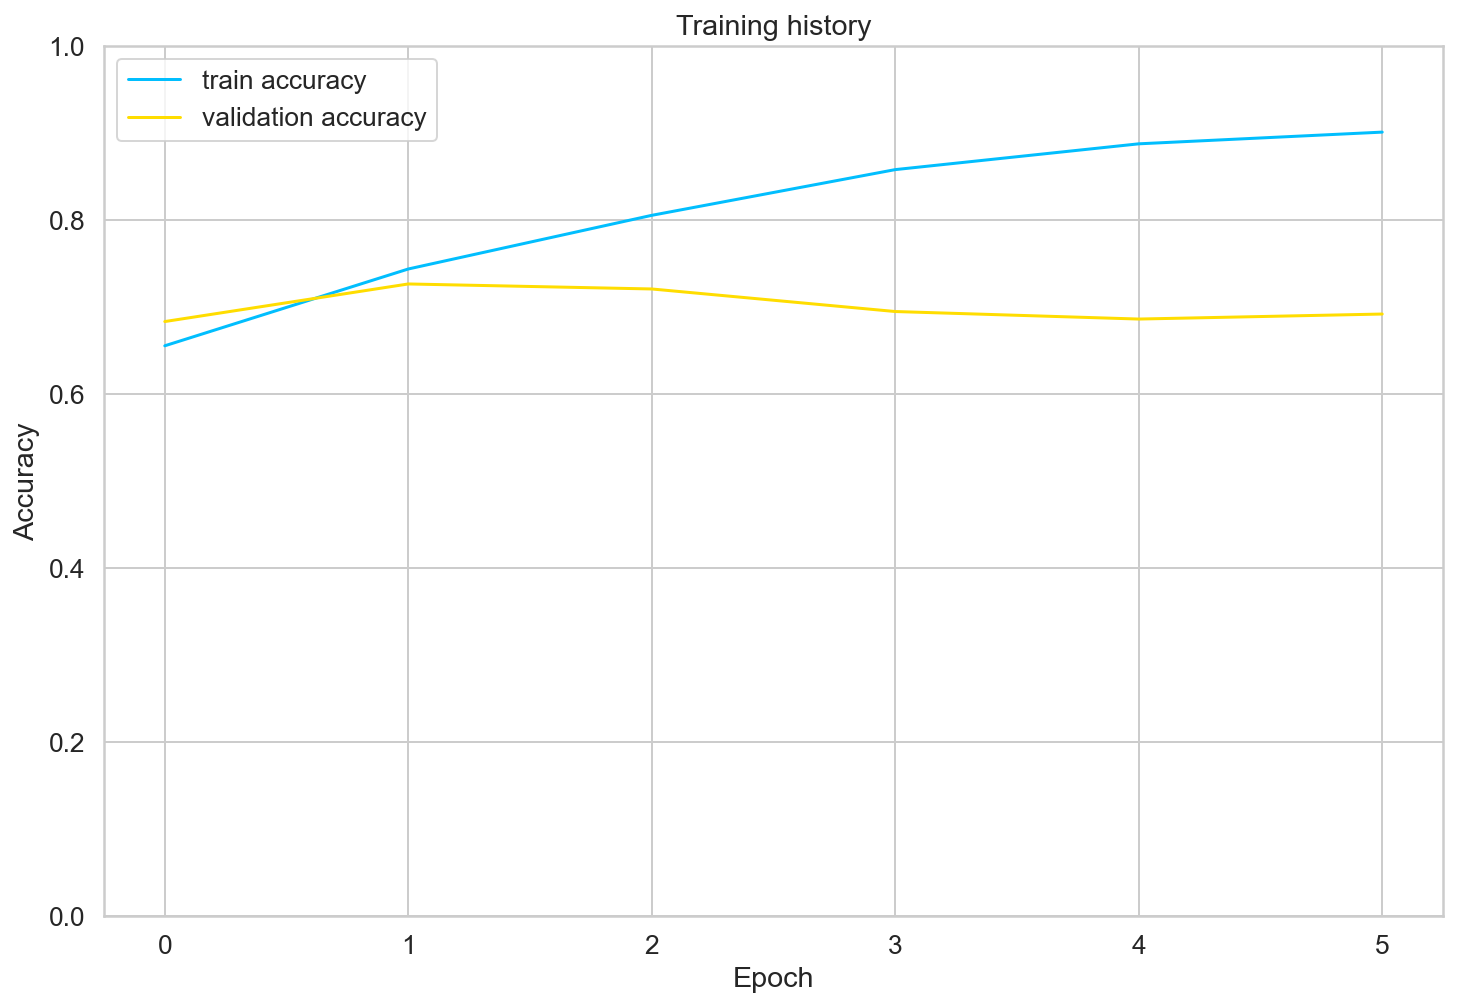

In [88]:
# training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [90]:
# accuracy on the testing set
test_acc, _ = eval_model(
  model1,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6887608069164265

In [28]:
# Helper function to get predictions
def get_predictions(model, data_loader):
    model = model.eval()
  
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [30]:
# classification report
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model1,
  test_data_loader
)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.31      0.31      0.31        36
     neutral       0.78      0.86      0.82       203
    positive       0.71      0.58      0.64       108

    accuracy                           0.71       347
   macro avg       0.60      0.58      0.59       347
weighted avg       0.71      0.71      0.71       347



In [31]:
# confusion matrix to display the performance of the model predictions
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

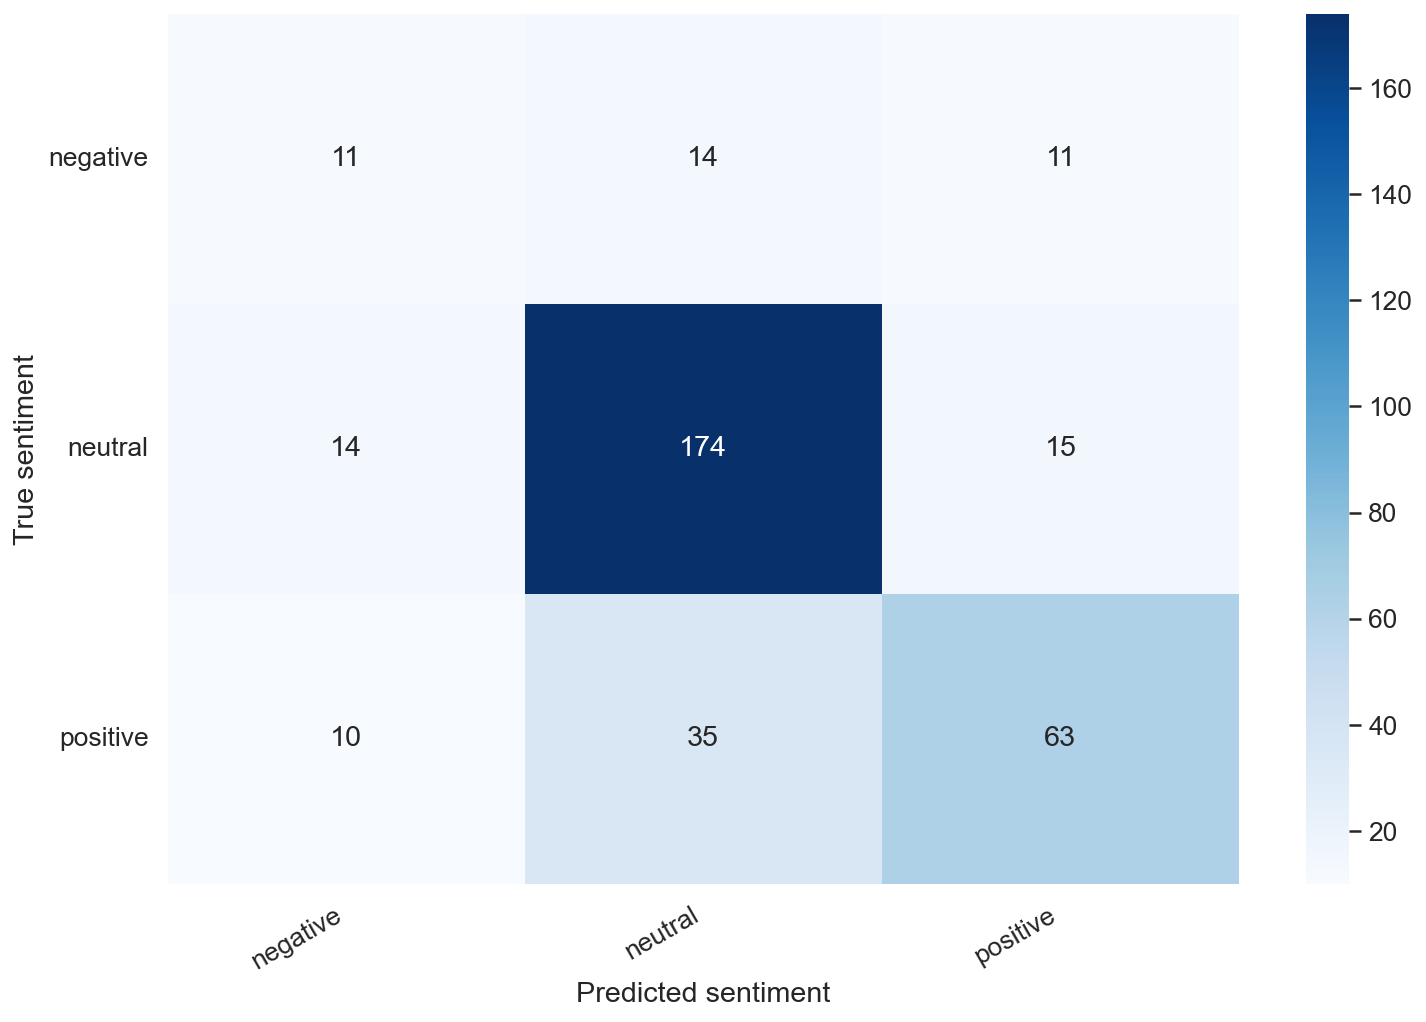

In [32]:


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


### DATA AUGMENTATION with transformers

In [33]:
import nlpaug.augmenter.word.context_word_embs as aug
from tqdm.auto import tqdm
from sklearn.utils import shuffle

In [34]:
# data augmentation
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

In [35]:
df2.sentiment.value_counts()

1    4236
2    1903
0     795
Name: sentiment, dtype: int64

In [36]:
#df2

In [37]:
# augmentation of the minority classes
def augmentMyData(df, augmenter,lab, repetitions=1, samples=200):
    augmented_texts = []
    # select only the minority class samples
    spam_df = df[df['sentiment'] == lab].reset_index(drop=True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(spam_df), samples)):
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(spam_df['tweet'].iloc[i])
            augmented_texts.append(augmented_text)

    data = {
        'sentiment': lab,
        'tweet': augmented_texts
    }
    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df



In [40]:
# positive class :2
aug_df1 = augmentMyData(df2,  augmenter,lab=2, samples=2500)

  0%|          | 0/2500 [00:00<?, ?it/s]

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_7853/4258959796.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = shuffle(df.append(aug_df).reset_index(drop=True))


In [41]:
# negative class :1
aug_df = augmentMyData(aug_df1, augmenter, lab=0, samples=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_7853/4258959796.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = shuffle(df.append(aug_df).reset_index(drop=True))


In [42]:
#new_df = df.drop(labels=['length', 'length_after_cleaning'], axis=1)
#new_df.head()
df2.sentiment.value_counts()

1    4236
2    1903
0     795
Name: sentiment, dtype: int64

In [43]:
aug_df.sentiment.value_counts()

2    4403
1    4236
0    3795
Name: sentiment, dtype: int64

In [44]:
# cleaning the dataset of tweets

aug_df.drop_duplicates
aug_df= cleaning_data(aug_df)
print(aug_df.shape)
aug_df.head()

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_7853/3033460231.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_7853/3033460231.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('[^A-Za-z0-9]+',' ')


(12434, 3)


,sentiment,tweet,clean_twt
9673,0,and can't but believe those idiots at black go...,believe idiot black google already waste much ...
4232,1,Will self-driving cars still honk at cyclists?,self drive car still honk cyclist
2730,1,Isn't a self driving car a robot?,self drive car robot
5606,1,Britain starts public trial of driverless cars...,britain start public trial driverless car
8589,1,Proudest moment of this week so far: Marginal ...,proudest moment week far marginal revolution l...


In [45]:
aug_df.sentiment.value_counts()

2    4403
1    4236
0    3795
Name: sentiment, dtype: int64

/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


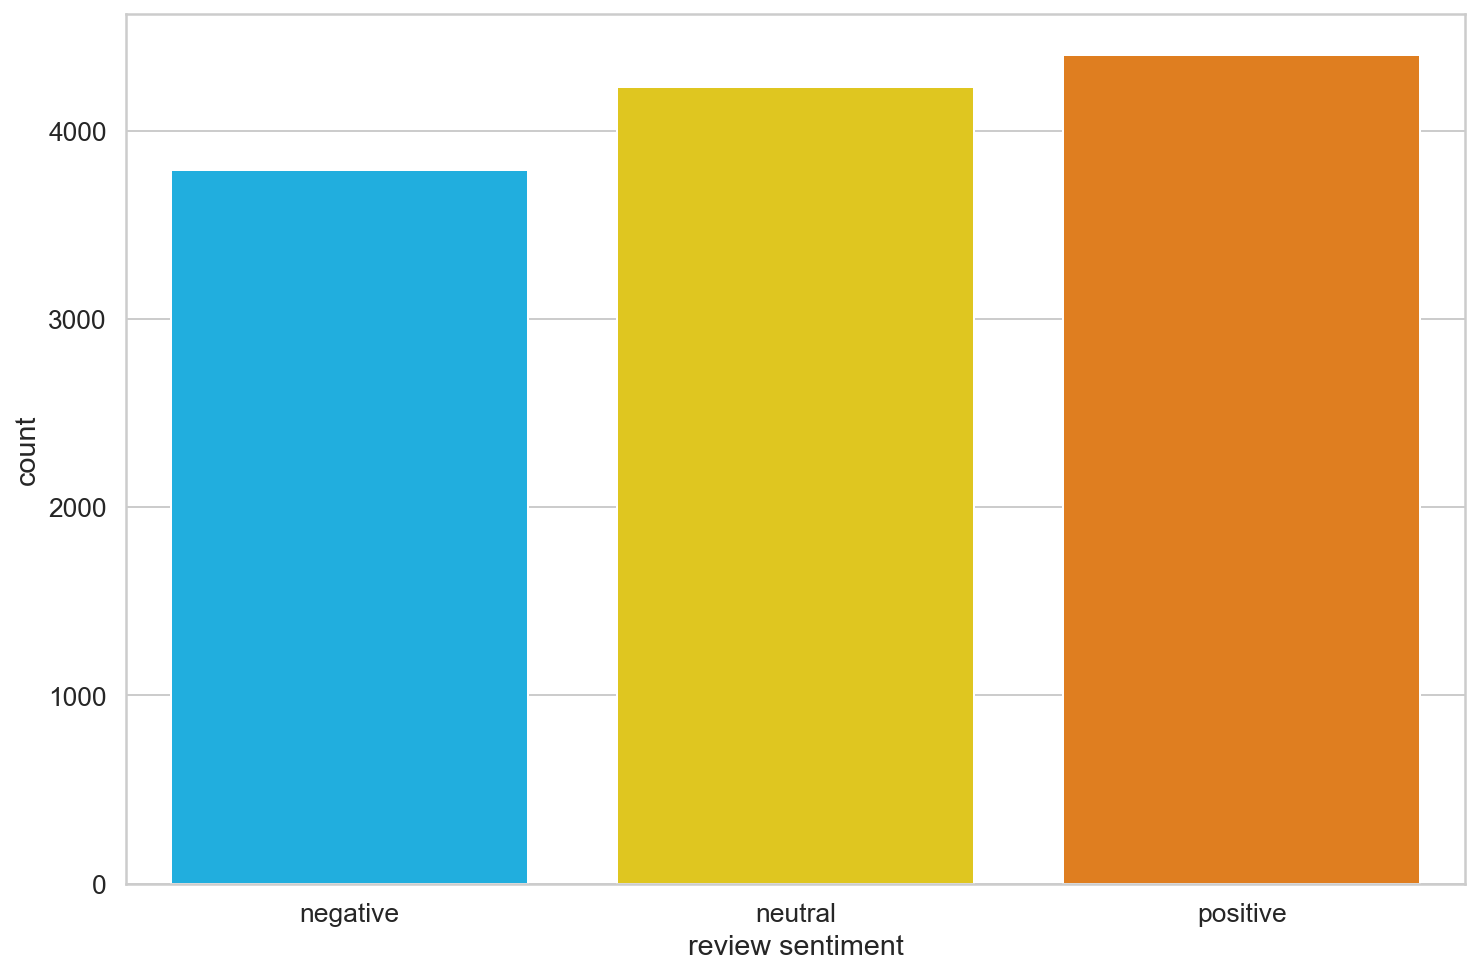

In [46]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(aug_df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [47]:
 df2.head(3)

,sentiment,tweet,clean_twt
0,2,Two places I'd invest all my money if I could:...,two place invest money could printing self dri...
1,2,Awesome! Google driverless cars will help the ...,awesome google driverless car help blind trave...
2,0,If Google maps can't keep up with road constru...,google map keep road construction suppose trus...


In [96]:
print("Original: ", df2.shape)
print("Augmented: ", aug_df.shape)
aug_df.sentiment.value_counts()

Original:  (6934, 3)
Augmented:  (12434, 3)


2    4403
1    4236
0    3795
Name: sentiment, dtype: int64

In [97]:
# split the dataset before augmenting to avoid augmented data in valid set
X_train, _, y_train, _ = train_test_split(aug_df['clean_twt'], aug_df['sentiment'].values, test_size=0.1)
_, X_test, _, y_test = train_test_split(df2['clean_twt'], df2['sentiment'].values, test_size=0.5)

In [98]:
# putting the data into dataframes
df_train=pd.DataFrame(X_train)
df_train["sentiment"]=y_train
print(df_train.shape)

df_test=pd.DataFrame(X_test)
df_test["sentiment"]=y_test
print(df_test.shape)

(11190, 2)
(3467, 2)


In [99]:

#df_train, df_test = train_test_split(df2, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((11190, 2), (1733, 2), (1734, 2))

In [100]:
# let's write them into csv files, in case:


df_train.shape, df_val.shape, df_test.shape

((11190, 2), (1733, 2), (1734, 2))

In [52]:
# creating the dataloader for the training
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [53]:
# moving the pytorch model to the GPU
model2 = SentimentClassifier(len(class_names))
model2 = model2.to(device)

# moving the example batch of the training data to the GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([16, 40])
torch.Size([16, 40])


In [54]:
# for the training
EPOCHS = 7

optimizer = AdamW(model2.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [56]:
# Training loop on our model
# training loop
#%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model2,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
      )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model2,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
      )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model2.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/7
----------
Train loss 0.6729128578943866 accuracy 0.7151921358355675
Val   loss 0.5305417006442307 accuracy 0.8026543566070398

Epoch 2/7
----------
Train loss 0.3819735155174775 accuracy 0.8642537980339589
Val   loss 0.34334608898797164 accuracy 0.8822850548182343

Epoch 3/7
----------
Train loss 0.23624052103143187 accuracy 0.9246648793565684
Val   loss 0.22309743076426172 accuracy 0.9290248124639354

Epoch 4/7
----------
Train loss 0.17075578072690406 accuracy 0.9541554959785523
Val   loss 0.22592618633403416 accuracy 0.9440276976341604

Epoch 5/7
----------
Train loss 0.119821399959536 accuracy 0.9694369973190349
Val   loss 0.19542967700591704 accuracy 0.9601846508944027

Epoch 6/7
----------
Train loss 0.09184122020253978 accuracy 0.9779267202859696
Val   loss 0.19096442104377057 accuracy 0.964800923254472

Epoch 7/7
----------
Train loss 0.07531200360132581 accuracy 0.9823056300268097
Val   loss 0.19875798663637095 accuracy 0.9642238892094633



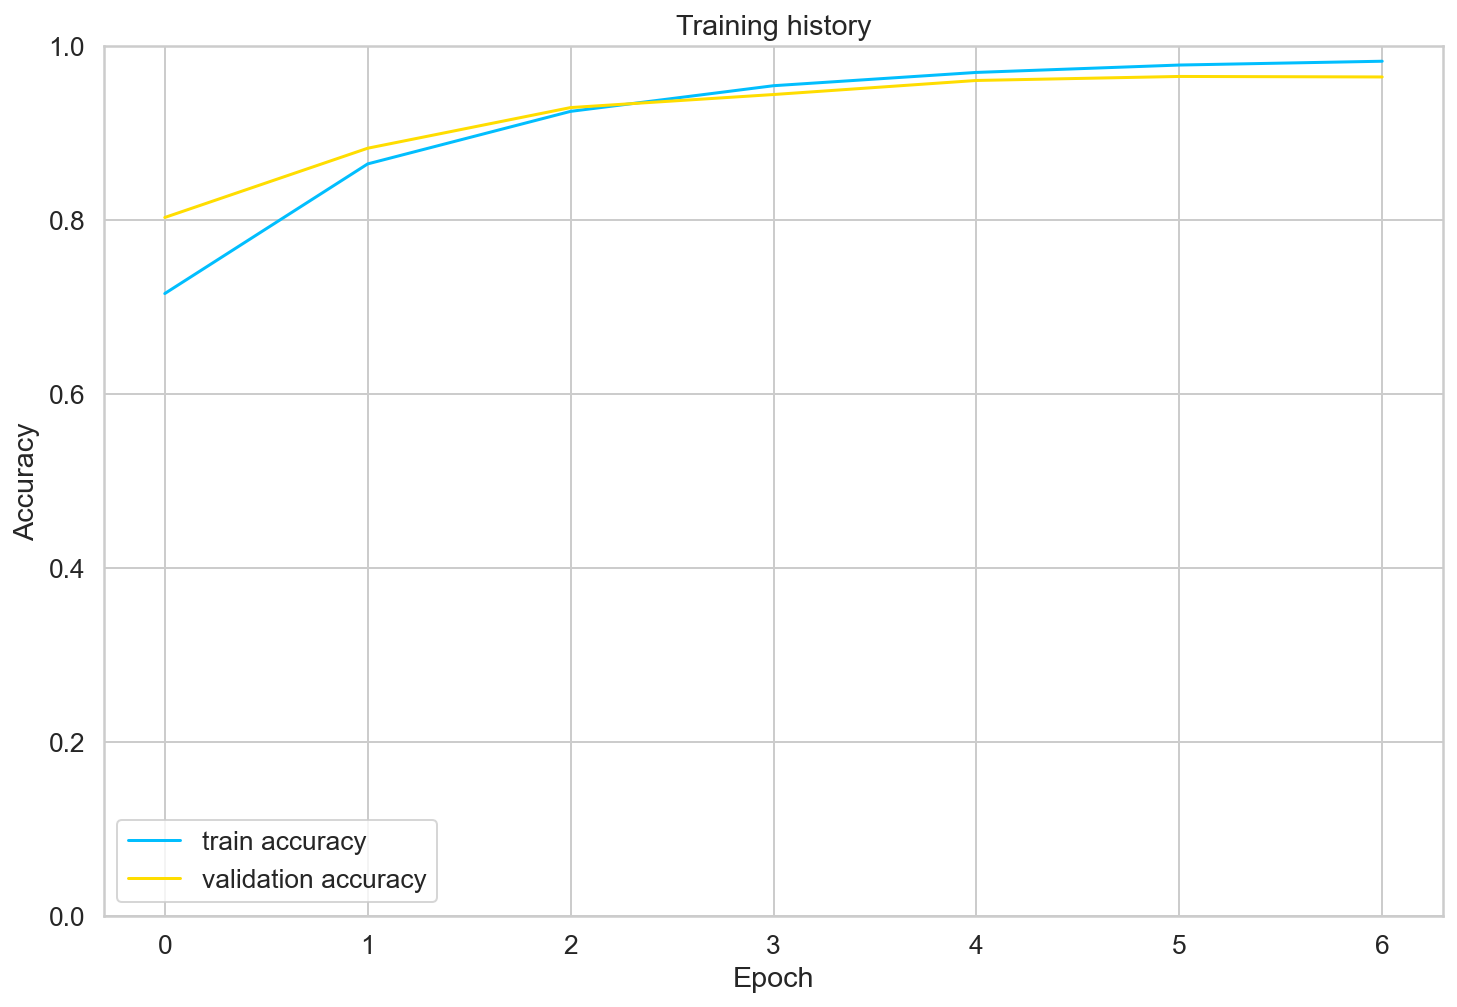

In [57]:
# training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [59]:
# accuracy on the testing set
test_acc, _ = eval_model(
  model2,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9630911188004614

In [61]:
# classification report
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model2,
  test_data_loader
)

              precision    recall  f1-score   support

    negative       0.96      0.95      0.95       186
     neutral       0.97      0.97      0.97      1099
    positive       0.94      0.95      0.95       449

    accuracy                           0.96      1734
   macro avg       0.96      0.96      0.96      1734
weighted avg       0.96      0.96      0.96      1734



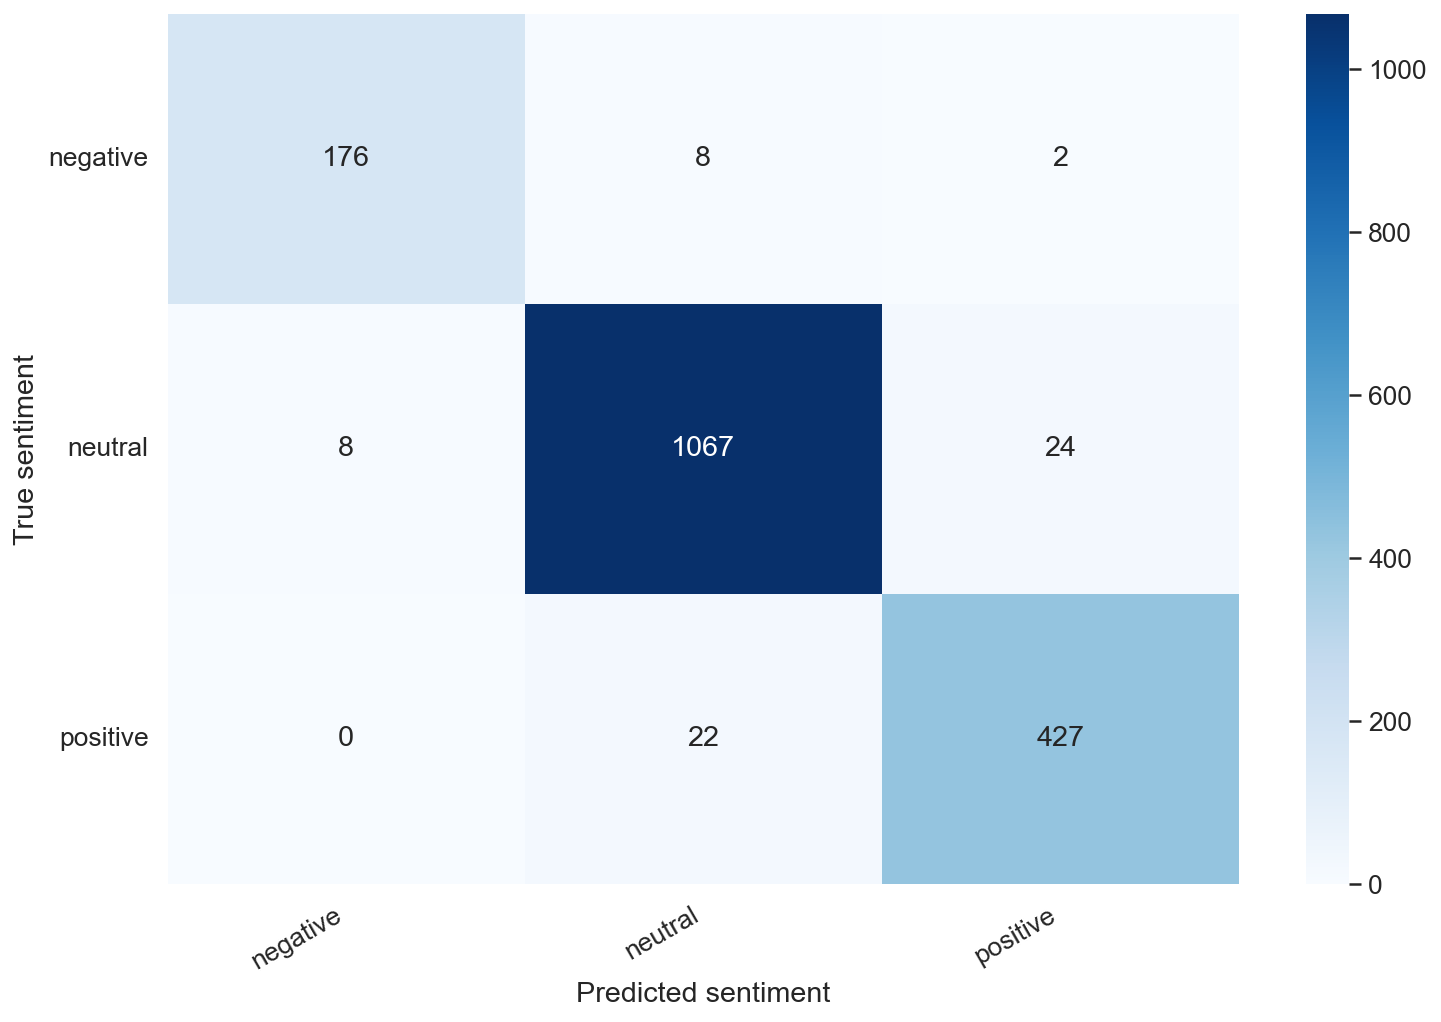

In [62]:

# classification report
print(classification_report(y_test, y_pred, target_names=class_names))

# confusion matrix

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [129]:
# change our 2nd model to model2


### Notes
It is possible to look into the predictions probabilities

what we've done
    - look for a labelled dataset containing people's opinions on AV (opinions and sentiment)
    - train a bert model for sentiment analysis on that dataset
    
next:
    - handle the imbalance in the dataset sentiment distribution
    - Fine tune the model
    - use the model to predict sentiment on our own scraped data

#### Next: prediction on our own dataset: twitter

In [130]:
data = pd.read_csv("autonomous vehicles accident 37.csv", encoding_errors='ignore')
data.head(3)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1539152933291544577,1539152933291544577,2022-06-21 03:47:10 Eastern Daylight Time,2022-06-21,03:47:10,-400,2195635628,edizioniesi,Edizioni ESI,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'user_id': None, 'username': None}",NaN,NaN,NaN,NaN
1,1538628309097005056,1538614441196998657,2022-06-19 17:02:29 Eastern Daylight Time,2022-06-19,17:02:29,-400,4534291,jimcollins,Jim Collins 🌹,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'user_id': '22226671', 'username': 'ACMESales...",NaN,NaN,NaN,NaN
2,1538504242176045057,1538503591672938497,2022-06-19 08:49:30 Eastern Daylight Time,2022-06-19,08:49:30,-400,270071690,worldcodation,Angel,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'user_id': '270071690', 'username': 'WorldCod...",NaN,NaN,NaN,NaN


In [137]:
# getting the tweets only
dataset= pd.DataFrame(data.tweet)
dataset.head()
print(dataset.shape)

(71, 1)


In [138]:
# cleaning the dataset of tweets

dataset.drop_duplicates
dataset= cleaning_data(dataset)
print(dataset.shape)
dataset.head()


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_2495/3033460231.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_twt'] = np.vectorize(remove_pattern)(df2['tweet'],'@[\w]*')
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_2495/3033460231.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_2495/3033460231.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

(37, 2)


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_2495/3033460231.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([ lemmatization(item) for item in str(x).split() if item not in stop]))
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_2495/3033460231.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))


,tweet,clean_twt
0,Who is liable when an accident caused by an au...,liable accident cause autonomous car occurs fo...
1,"@ACMESalesRep @mateosfo @markos ""Autonomous ve...",autonomous vehicle order magnitude safer preve...
2,Solution?: Do not allow autonomous vehicles to...,solution allow autonomous vehicle put insuranc...
3,An added benefit to testing autonomous vehicle...,add benefit test autonomous vehicle virtual wo...
4,@Trojan24x7Usc Fully autonomous vehicles are n...,fully autonomous vehicle nearly impossible mak...


/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


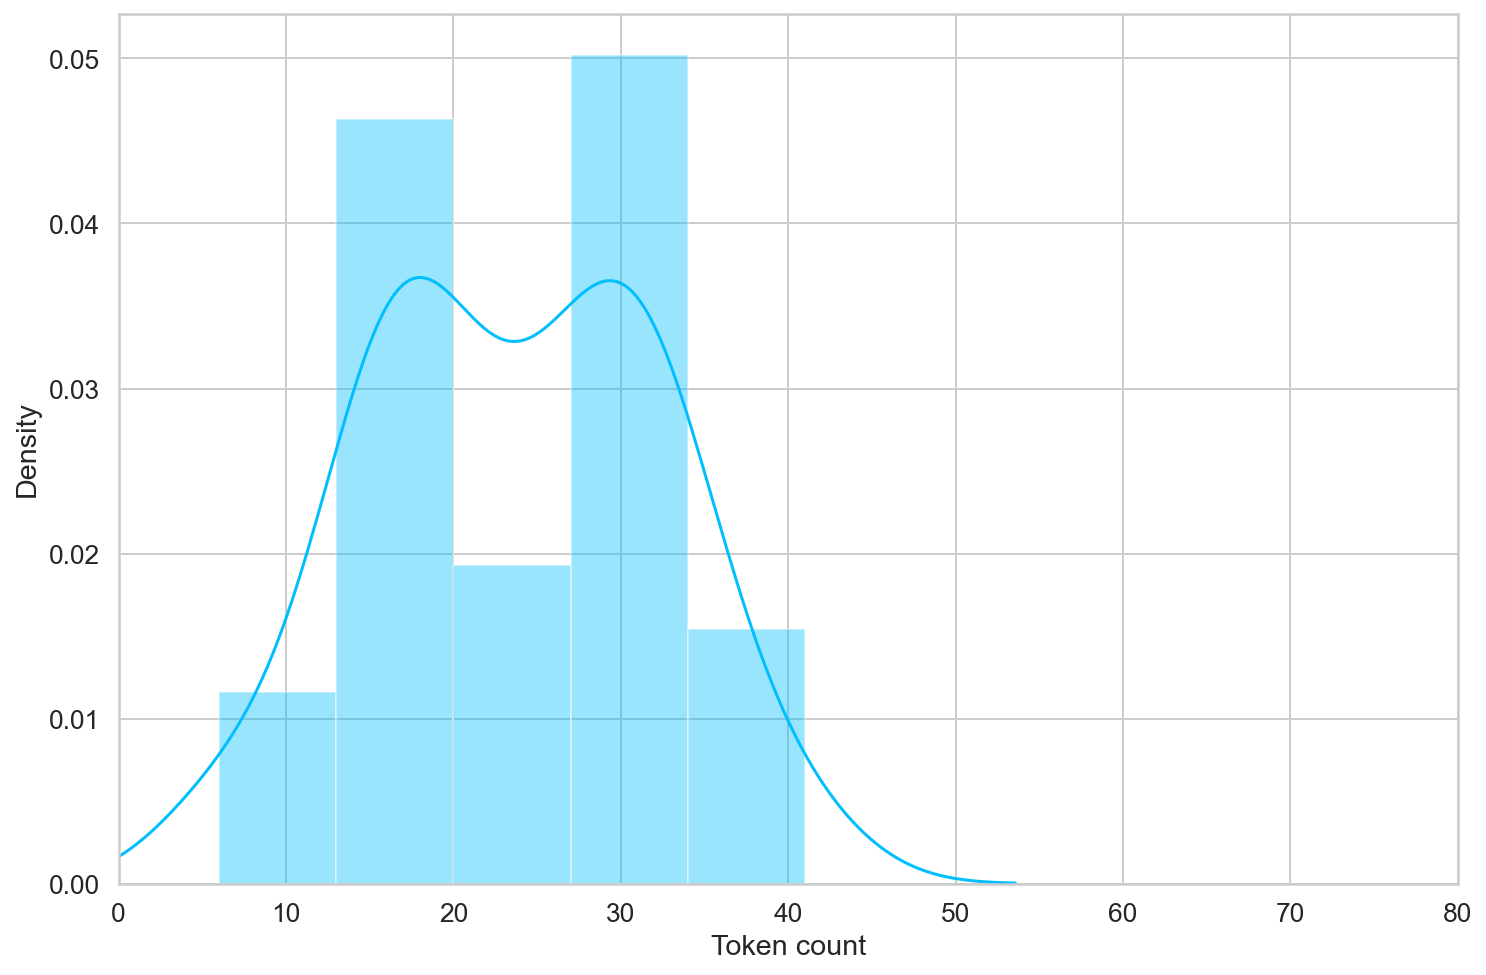

In [139]:
# getting the maximum length of the tweets
token_lens = []

for txt in dataset.clean_twt:
    tokens = tokenizer.encode(txt, max_length=812)
    token_lens.append(len(tokens))
#plot distrib 
sns.distplot(token_lens)
plt.xlim([0, 80]);
plt.xlabel('Token count');

In [91]:
max(token_lens)

41

In [140]:
#max len less than 45, will set to 50
MAX_LEN = 50

In [38]:
#dataset.shape

In [40]:
# encoding the texxxt and predicting
predictions=[]
#i=0
for item in dataset.clean_twt.to_numpy():
    #i+=1
    encoded_review = tokenizer.encode_plus(
    #review_text,
    item,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    )

    # predictions from our model
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    predictions.append( int(prediction.item()) )
#print(i)
#print(f'Review text: {review_text}')
#print(f'Sentiment  : {class_names[prediction]}')

/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [217]:
# np.array(predictions)

In [216]:
# print(f'Review text: {review_text}')
# print(f'Sentiment  : {class_names[prediction]}')

/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


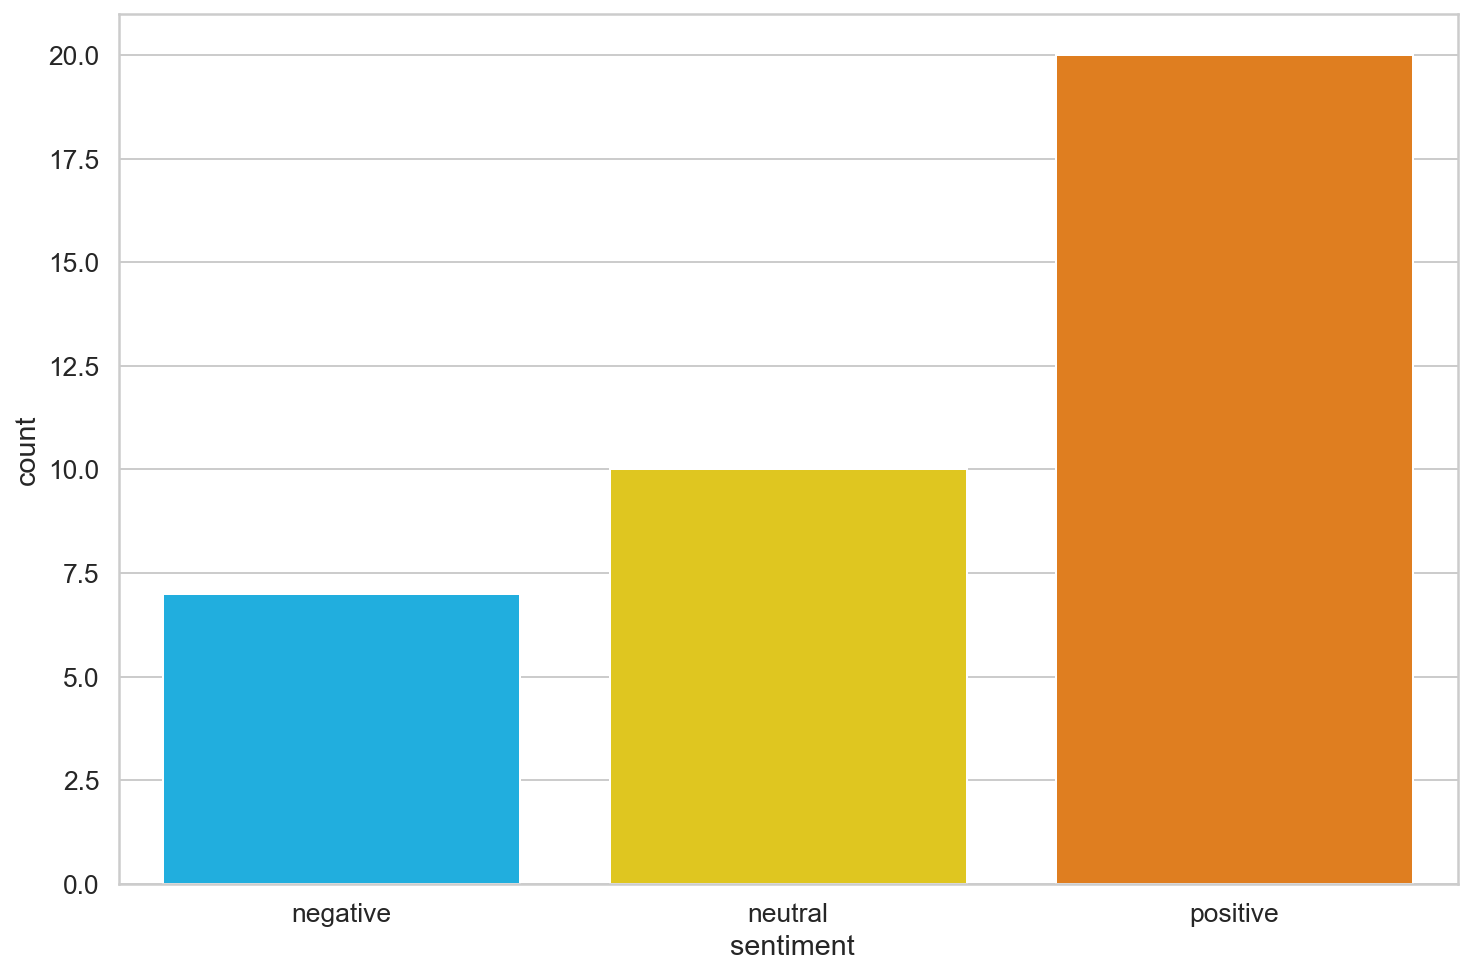

In [41]:
# vizualising the preds
ax = sns.countplot(predictions)
plt.xlabel(' sentiment')
ax.set_xticklabels(class_names);

In [ ]:
# predictions with our 2nd model: model 2

In [141]:
#
# encoding the texxxt and predicting
#review_text = "I love completing my todos! Best app ever!!!"
predictions=[]
#i=0
for item in dataset.clean_twt.to_numpy():
    #i+=1
    encoded_review = tokenizer.encode_plus(
    #review_text,
    item,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    )

    # predictions from our model
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model2(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    predictions.append( int(prediction.item()) )
#print(i)
#print(f'Review text: {review_text}')
#print(f'Sentiment  : {class_names[prediction]}')

/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


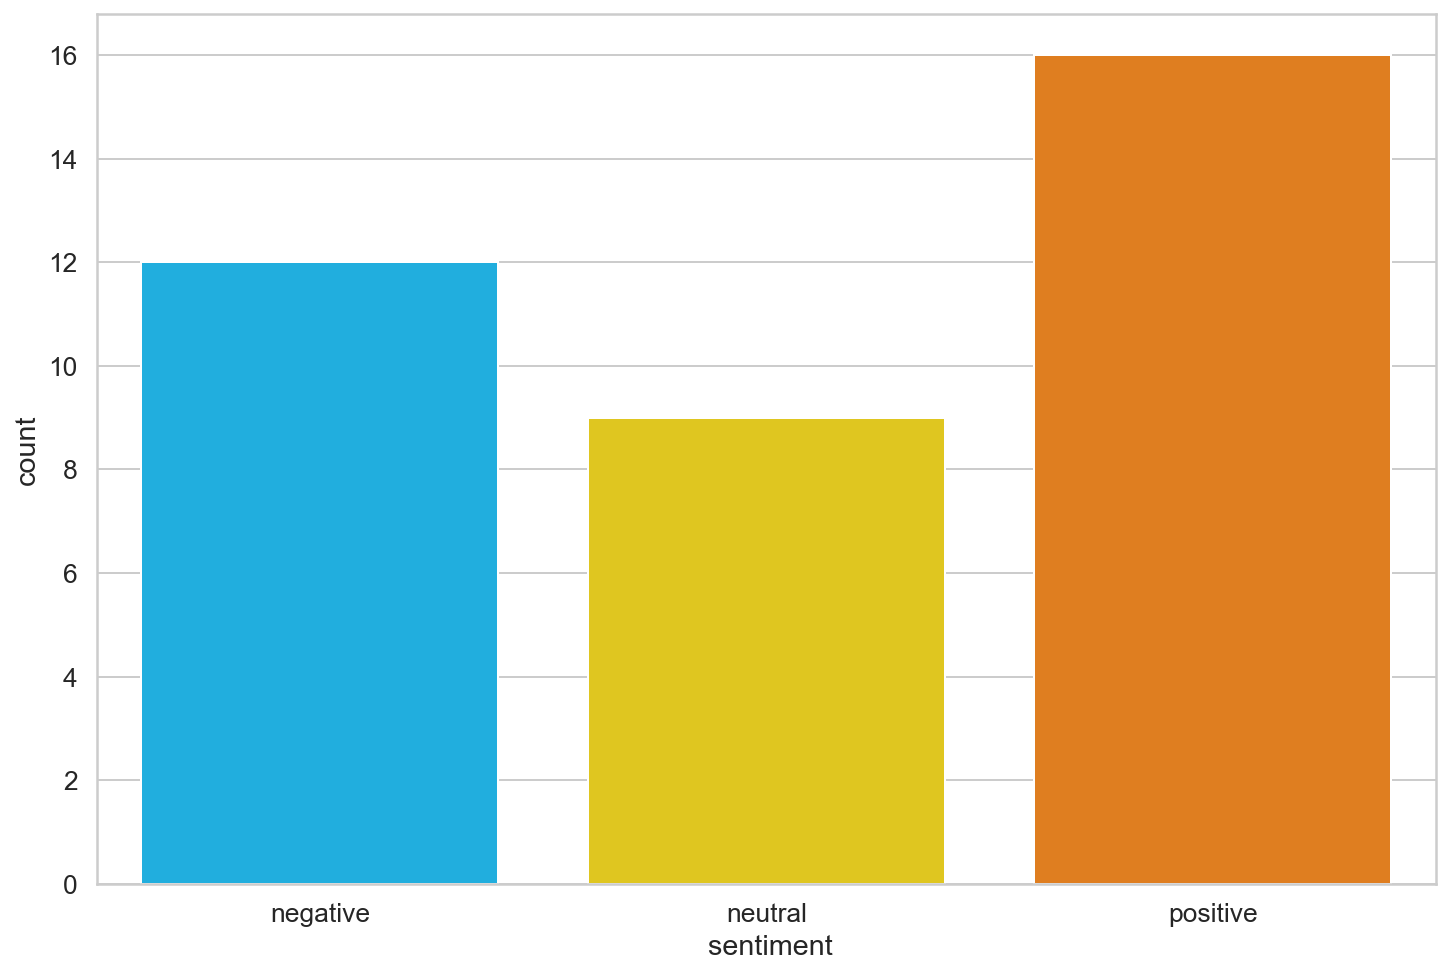

In [142]:
# vizualising the preds
ax = sns.countplot(predictions)
plt.xlabel(' sentiment')
ax.set_xticklabels(class_names);

In [ ]:
source:
    https://yasha-joshi.medium.com/sentiment-analysis-for-self-driving-cars-30c03a6b1f8c
    https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=VA_wGSLQLKCh
    https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/PREPROCESSING%20TECHNIQUES/spam_handling_imbalanced_data.ipynb